<a href="https://colab.research.google.com/github/chookiantatt/HDB-Resale-Flat-Price-Prediction/blob/main/HDB_Resale_Flat_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**


Development of civilization is the foundation of the increase in demand for houses day by day, especially in Singapore, a country with limited land area, resale flat is one of the most profitable investments.
We all know that a house price is a number from some defined assortment, so obviously prediction of prices of houses is a regression task.
In this project, the main objective is to predict HDB resale flat price based on various key features, for example, the location of housing(i.e distance from amenities and MRT stations). Some other significant features will be added in to enhance the prediction accuracy.

Credits: https://medium.com/@michael.wy.ong/web-scrape-geospatial-data-analyse-singapores-property-price-part-i-276caba320b

Reference: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurelien Geron

In [2]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import math
import json
import os

In [3]:
# mounted at /content/drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Web-scraping Data & Exploratory Data Analysis (EDA)**

The dataset is downloaded from data.gov.sg website, it includes HDB Resale Flat price from January 2017 onwards.

In [4]:
resale_price_path = '/content/drive/MyDrive/Colab Notebooks/Housing/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv'
df_resale = pd.read_csv(resale_price_path)
df_resale.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [5]:
# Let's check info of the dataset
df_resale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143552 entries, 0 to 143551
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                143552 non-null  object 
 1   town                 143552 non-null  object 
 2   flat_type            143552 non-null  object 
 3   block                143552 non-null  object 
 4   street_name          143552 non-null  object 
 5   storey_range         143552 non-null  object 
 6   floor_area_sqm       143552 non-null  float64
 7   flat_model           143552 non-null  object 
 8   lease_commence_date  143552 non-null  int64  
 9   remaining_lease      143552 non-null  object 
 10  resale_price         143552 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 12.0+ MB


In [6]:
df_resale.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,143552.000000,143552.000000,1.435520e+05
mean,97.662147,1995.475326,4.765233e+05
std,24.078464,13.696471,1.649986e+05
min,31.000000,1966.000000,1.400000e+05
25%,82.000000,1985.000000,3.550000e+05
50%,94.000000,1996.000000,4.450000e+05
75%,113.000000,2006.000000,5.638880e+05
max,249.000000,2019.000000,1.418000e+06


There are only two numerical features(floor_area_sqm,lease_commence_date), which are not sufficient for a good prediction model. Additional numerical features will be added later.

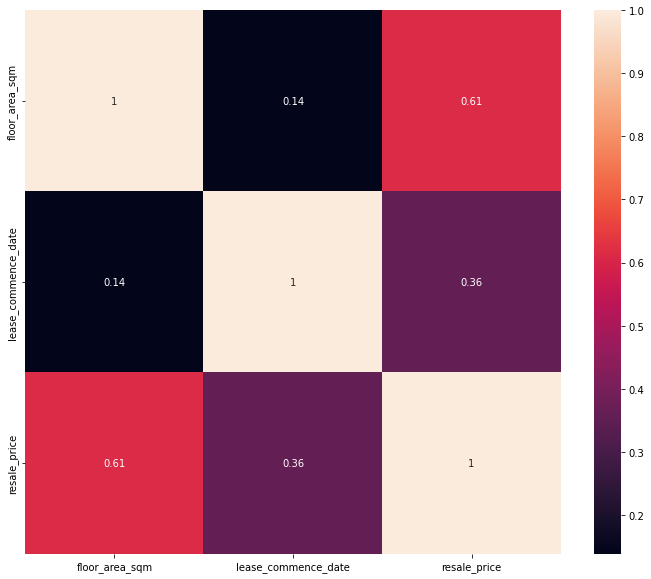

In [7]:
# Let's check the correlation of two numerical features(floor_area_sqm,lease_commence_date) with target variable(resale_price)
plt.figure(figsize=(12,10))
sns.heatmap(df_resale.corr(), annot=True)
plt.show()

Feature(floor_area_sqm) has high correlation with target variable(resale_price), whereas feature(lease_commence_date) has low correlation. Therefore, we can drop feature(lease_commence_date).

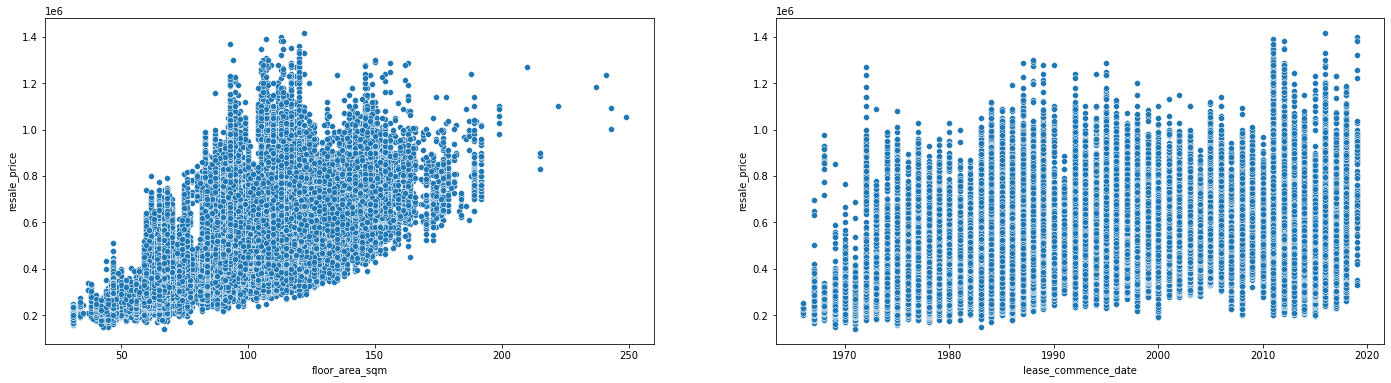

In [8]:
plt.figure(figsize=(24,6))

plt.subplot(1,2,1) #plot one row two columns of figure, places figure at the left most column
sns.scatterplot(data=df_resale, x='floor_area_sqm', y='resale_price')

plt.subplot(1,2,2) 
sns.scatterplot(data=df_resale, x='lease_commence_date', y='resale_price')
plt.show()

Let's consider a numerical feature to be added in dataset, which is the distance beween the resale flats and their nearest MRT stations. Given block number and street name, onemap.sg will be used to locate the resale flat's coordinate(i.e latitude & longitude)

In [9]:
# Combine block number and street name into new column 'address'
df_resale['address'] = df_resale['block'] + ' ' + df_resale['street_name']
df_resale.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,108 ANG MO KIO AVE 4
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,602 ANG MO KIO AVE 5
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,465 ANG MO KIO AVE 10
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,601 ANG MO KIO AVE 5


In [10]:
all_address = list(df_resale['address'])
unique_address = list(set(all_address)) 
print('There are {} unique addresses out of {} housing transations'.format(len(unique_address), len(df_resale)))

There are 9385 unique addresses out of 143552 housing transations


In [11]:
filepath = '/content/drive/MyDrive/Colab Notebooks/Housing/'

Function below is defined for future reusability if there are new amenities (e.g schools, supermarkets, hawker centres etc). It can save the coordinates and addresses to a csv file.

In [12]:
def find_postal(lst, filename):
    '''With the block number and street name, get the full address of the hdb flat,
    including the postal code, geogaphical coordinates (lat/long)'''
    
    for index,add in enumerate(lst):
        url= "https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal="+ add        
        if (index + 1) % 100 == 0:
          print(index + 1, url)
        
        # Retrieve information from website
        response = requests.get(url)
        data = json.loads(response.text) 
    
        temp_df = pd.DataFrame.from_dict(data["results"])
        temp_df["address"] = add
        
        # Create the file with the first row that is read in 
        if index == 0:
            file = temp_df
        else:
            file = file.append(temp_df)
    file.to_csv(filepath + filename + '.csv')

In [13]:
find_postal(lst=unique_address, filename='full_address')

100 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=512 JELAPANG RD
200 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=255 SIMEI ST 1
300 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=282 YISHUN AVE 6
400 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=468 SEGAR RD
500 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=812 YISHUN RING RD
600 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=11 JOO SENG RD
700 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=225B COMPASSVALE WALK
800 https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal=673A CHOA CHU KANG CRES
900 https://developers.onemap.sg/commonapi/search?returnGeo

In [14]:
geo = pd.read_csv(filepath + 'full_address.csv')
geo.head()

,Unnamed: 0,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,LONGTITUDE,address
0,0,659B JURONG WEST STREET 65 SINGAPORE 642659,659B,JURONG WEST STREET 65,NIL,659B JURONG WEST STREET 65 SINGAPORE 642659,642659,13383.626808,35454.323758,1.336907,103.701982,103.701982,659B JURONG WEST ST 65
1,0,PUNGGOL GROVE,294,PUNGGOL CENTRAL,PUNGGOL GROVE,294 PUNGGOL CENTRAL PUNGGOL GROVE SINGAPORE 82...,820294,35936.600039,42714.902148,1.402572,103.904635,103.904635,294 PUNGGOL CTRL
2,0,605 CLEMENTI WEST STREET 1 SINGAPORE 120605,605,CLEMENTI WEST STREET 1,NIL,605 CLEMENTI WEST STREET 1 SINGAPORE 120605,120605,20732.898986,31968.442523,1.305385,103.768020,103.768020,605 CLEMENTI WEST ST 1
3,0,DBS TOA PAYOH LORONG 4/73,73,LORONG 4 TOA PAYOH,DBS TOA PAYOH LORONG 4/73,73 LORONG 4 TOA PAYOH DBS TOA PAYOH LORONG 4/7...,310073,30047.253992,35167.851700,1.334320,103.851714,103.851714,73 LOR 4 TOA PAYOH
4,0,GEYLANG EAST GROVE,125,GEYLANG EAST AVENUE 1,GEYLANG EAST GROVE,125 GEYLANG EAST AVENUE 1 GEYLANG EAST GROVE S...,381125,33904.522691,33301.830625,1.317444,103.886374,103.886374,125 GEYLANG EAST AVE 1


In [15]:
geo.rename(columns={'Unnamed: 0': 'INDICATOR'}, inplace=True)
geo.head()

,INDICATOR,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,LONGTITUDE,address
0,0,659B JURONG WEST STREET 65 SINGAPORE 642659,659B,JURONG WEST STREET 65,NIL,659B JURONG WEST STREET 65 SINGAPORE 642659,642659,13383.626808,35454.323758,1.336907,103.701982,103.701982,659B JURONG WEST ST 65
1,0,PUNGGOL GROVE,294,PUNGGOL CENTRAL,PUNGGOL GROVE,294 PUNGGOL CENTRAL PUNGGOL GROVE SINGAPORE 82...,820294,35936.600039,42714.902148,1.402572,103.904635,103.904635,294 PUNGGOL CTRL
2,0,605 CLEMENTI WEST STREET 1 SINGAPORE 120605,605,CLEMENTI WEST STREET 1,NIL,605 CLEMENTI WEST STREET 1 SINGAPORE 120605,120605,20732.898986,31968.442523,1.305385,103.768020,103.768020,605 CLEMENTI WEST ST 1
3,0,DBS TOA PAYOH LORONG 4/73,73,LORONG 4 TOA PAYOH,DBS TOA PAYOH LORONG 4/73,73 LORONG 4 TOA PAYOH DBS TOA PAYOH LORONG 4/7...,310073,30047.253992,35167.851700,1.334320,103.851714,103.851714,73 LOR 4 TOA PAYOH
4,0,GEYLANG EAST GROVE,125,GEYLANG EAST AVENUE 1,GEYLANG EAST GROVE,125 GEYLANG EAST AVENUE 1 GEYLANG EAST GROVE S...,381125,33904.522691,33301.830625,1.317444,103.886374,103.886374,125 GEYLANG EAST AVE 1


In [16]:
# Keep only columns 'address', 'latitude', 'longitude'
geo_edited = geo.drop(columns=['SEARCHVAL', 'BLK_NO', 'ROAD_NAME', 'BUILDING', 'LONGTITUDE'])
geo_edited.head()

,INDICATOR,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,address
0,0,659B JURONG WEST STREET 65 SINGAPORE 642659,642659,13383.626808,35454.323758,1.336907,103.701982,659B JURONG WEST ST 65
1,0,294 PUNGGOL CENTRAL PUNGGOL GROVE SINGAPORE 82...,820294,35936.600039,42714.902148,1.402572,103.904635,294 PUNGGOL CTRL
2,0,605 CLEMENTI WEST STREET 1 SINGAPORE 120605,120605,20732.898986,31968.442523,1.305385,103.768020,605 CLEMENTI WEST ST 1
3,0,73 LORONG 4 TOA PAYOH DBS TOA PAYOH LORONG 4/7...,310073,30047.253992,35167.851700,1.334320,103.851714,73 LOR 4 TOA PAYOH
4,0,125 GEYLANG EAST AVENUE 1 GEYLANG EAST GROVE S...,381125,33904.522691,33301.830625,1.317444,103.886374,125 GEYLANG EAST AVE 1


In [17]:
geo_add_lat_long = geo_edited.copy()
geo_add_lat_long = geo_add_lat_long[geo_add_lat_long['INDICATOR'] == 0]
geo_add_lat_long.drop(columns=['INDICATOR', 'POSTAL', 'X', 'Y', 'address'], inplace=True)
geo_add_lat_long.head()

,ADDRESS,LATITUDE,LONGITUDE
0,659B JURONG WEST STREET 65 SINGAPORE 642659,1.336907,103.701982
1,294 PUNGGOL CENTRAL PUNGGOL GROVE SINGAPORE 82...,1.402572,103.904635
2,605 CLEMENTI WEST STREET 1 SINGAPORE 120605,1.305385,103.768020
3,73 LORONG 4 TOA PAYOH DBS TOA PAYOH LORONG 4/7...,1.334320,103.851714
4,125 GEYLANG EAST AVENUE 1 GEYLANG EAST GROVE S...,1.317444,103.886374


The list of MRT stations can be found at https://github.com/hxchua/datadoubleconfirm/blob/master/datasets/mrtsg.csv with latitude and longitude provided

In [18]:
mrt_geo = pd.read_csv(filepath + 'mrtsg.csv')
mrt_geo.head()

,OBJECTID,STN_NAME,STN_NO,X,Y,Latitude,Longitude,COLOR
0,12,ADMIRALTY MRT STATION,NS10,24402.1063,46918.1131,1.440585,103.800998,RED
1,16,ALJUNIED MRT STATION,EW9,33518.6049,33190.0020,1.316433,103.882893,GREEN
2,33,ANG MO KIO MRT STATION,NS16,29807.2655,39105.7720,1.369933,103.849553,RED
3,81,BAKAU LRT STATION,SE3,36026.0821,41113.8766,1.388093,103.905418,OTHERS
4,80,BANGKIT LRT STATION,BP9,21248.2460,40220.9693,1.380018,103.772667,OTHERS


In [19]:
# Keep only columns 'STN_NAME', 'Latitude' & 'Longitude'
mrt_add_lat_long = pd.DataFrame(pd.concat([mrt_geo[column] for column in ['STN_NAME', 'Latitude', 'Longitude']], axis=1))
mrt_add_lat_long.head()

,STN_NAME,Latitude,Longitude
0,ADMIRALTY MRT STATION,1.440585,103.800998
1,ALJUNIED MRT STATION,1.316433,103.882893
2,ANG MO KIO MRT STATION,1.369933,103.849553
3,BAKAU LRT STATION,1.388093,103.905418
4,BANGKIT LRT STATION,1.380018,103.772667


Let's determine the distance between each resale flat and it's nearest MRT stations. Define a function which it can be reused for other amenities.

In [20]:
from geopy.distance import geodesic

def find_nearest(housing, amenity):
    results = {}
    for index, flat in enumerate(housing.iloc[:, 0]):
        flat_loc = (housing.iloc[index, 1], housing.iloc[index, 2])
        flat_amenity = ['', '', 100]
        for ind, eachloc in enumerate(amenity.iloc[:, 0]):
            amenity_loc = (amenity.iloc[ind, 1], amenity.iloc[ind, 2])
            distance = geodesic(flat_loc, amenity_loc)
            if distance < flat_amenity[2]:
                flat_amenity[0] = flat
                flat_amenity[1] = eachloc
                flat_amenity[2] = distance
        results[flat] = (flat_amenity[1], flat_amenity[2])
        if (index + 1) % 100 == 0:
          print(index + 1, '-', flat, ':', results[flat])
    return results

Note that the function takes in two DataFrames with the second and third columns being the latitude and longitude of the locations (i.e., flat or MRT station). The first column could be any feature that identifies the location of its corresponding row (e.g., address of flat or name of MRT station).

In [21]:
distance_mrt = find_nearest(geo_add_lat_long, mrt_add_lat_long)

100 - 512 JELAPANG ROAD PANGSHAN COURT SINGAPORE 670512 : ('SEGAR LRT STATION', Distance(0.15920473075931696))
200 - 255 SIMEI STREET 1 SINGAPORE 520255 : ('SIMEI MRT STATION', Distance(0.19556817484125058))
300 - 282 YISHUN AVENUE 6 FICUS VALE SINGAPORE 760282 : ('CANBERRA MRT STATION', Distance(1.0532708014433698))
400 - 468 SEGAR ROAD SEGAR GARDENS SINGAPORE 670468 : ('SEGAR LRT STATION', Distance(0.429657348927554))
500 - 812 YISHUN RING ROAD KHATIB GARDENS SINGAPORE 760812 : ('KHATIB MRT STATION', Distance(0.09187776114792552))
600 - 11 JOO SENG ROAD SINGAPORE 360011 : ('TAI SENG MRT STATION', Distance(0.8330712069591175))
700 - 225B COMPASSVALE WALK COMPASSVALE VISTA SINGAPORE 542225 : ('RANGGUNG LRT STATION', Distance(0.4456144355081243))
800 - 673A CHOA CHU KANG CRESCENT SINGAPORE 681673 : ('YEW TEE MRT STATION', Distance(0.3848474163455168))
900 - 216 ANG MO KIO AVENUE 1 ANG MO KIO 22 SINGAPORE 560216 : ('ANG MO KIO MRT STATION', Distance(0.9863933149564551))
1000 - 292 TAMPIN

In [22]:
df_distance_mrt = pd.DataFrame(distance_mrt).T.reset_index()
df_distance_mrt

,index,0,1
0,659B JURONG WEST STREET 65 SINGAPORE 642659,BOON LAY MRT STATION,0.4951383252102456 km
1,294 PUNGGOL CENTRAL PUNGGOL GROVE SINGAPORE 82...,PUNGGOL MRT STATION,0.36103644362279186 km
2,605 CLEMENTI WEST STREET 1 SINGAPORE 120605,CLEMENTI MRT STATION,1.1000992613846943 km
3,73 LORONG 4 TOA PAYOH DBS TOA PAYOH LORONG 4/7...,TOA PAYOH MRT STATION,0.5051274000167447 km
4,125 GEYLANG EAST AVENUE 1 GEYLANG EAST GROVE S...,ALJUNIED MRT STATION,0.4031881263729335 km
...,...,...,...
9377,82B LORONG 4 TOA PAYOH SINGAPORE 312082,TOA PAYOH MRT STATION,0.36366195049783245 km
9378,690E WOODLANDS DRIVE 75 SINGAPORE 735690,ADMIRALTY MRT STATION,0.8029670748243034 km
9379,634 JURONG WEST STREET 65 SINGAPORE 640634,PIONEER MRT STATION,0.6316591488252721 km
9380,370 HOUGANG STREET 31 SINGAPORE 530370,KOVAN MRT STATION,0.6445527373177035 km


In [23]:
df_distance_mrt = df_distance_mrt.rename(columns={'index':'ADDRESS', 0:'MRT STATION', 1:'DISTANCE_MRT'})
df_distance_mrt

,ADDRESS,MRT STATION,DISTANCE_MRT
0,659B JURONG WEST STREET 65 SINGAPORE 642659,BOON LAY MRT STATION,0.4951383252102456 km
1,294 PUNGGOL CENTRAL PUNGGOL GROVE SINGAPORE 82...,PUNGGOL MRT STATION,0.36103644362279186 km
2,605 CLEMENTI WEST STREET 1 SINGAPORE 120605,CLEMENTI MRT STATION,1.1000992613846943 km
3,73 LORONG 4 TOA PAYOH DBS TOA PAYOH LORONG 4/7...,TOA PAYOH MRT STATION,0.5051274000167447 km
4,125 GEYLANG EAST AVENUE 1 GEYLANG EAST GROVE S...,ALJUNIED MRT STATION,0.4031881263729335 km
...,...,...,...
9377,82B LORONG 4 TOA PAYOH SINGAPORE 312082,TOA PAYOH MRT STATION,0.36366195049783245 km
9378,690E WOODLANDS DRIVE 75 SINGAPORE 735690,ADMIRALTY MRT STATION,0.8029670748243034 km
9379,634 JURONG WEST STREET 65 SINGAPORE 640634,PIONEER MRT STATION,0.6316591488252721 km
9380,370 HOUGANG STREET 31 SINGAPORE 530370,KOVAN MRT STATION,0.6445527373177035 km


In [24]:
df_distance_mrt.to_csv(filepath + 'distance_mrt.csv', index=False)

In [25]:
# Let's merge this with original dataset

hdb = df_resale.merge(geo_edited[geo_edited['INDICATOR'] == 0], how='left', left_on='address', right_on='address')
hdb.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,INDICATOR,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10,0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,560406,30288.234663,38229.067463,1.362005,103.853880
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,108 ANG MO KIO AVE 4,0,108 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...,560108,28543.458747,39220.009892,1.370966,103.838202
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,602 ANG MO KIO AVE 5,0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,560602,28228.099954,40297.283149,1.380709,103.835368
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,465 ANG MO KIO AVE 10,0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,560465,30657.824693,38693.098657,1.366201,103.857201
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,601 ANG MO KIO AVE 5,0,601 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,560601,28201.782245,40334.052030,1.381041,103.835132


In [26]:
hdb = hdb.merge(df_distance_mrt, how='left', left_on='ADDRESS', right_on='ADDRESS')
hdb.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,address,INDICATOR,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,MRT STATION,DISTANCE_MRT
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,...,406 ANG MO KIO AVE 10,0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,560406,30288.234663,38229.067463,1.362005,103.853880,ANG MO KIO MRT STATION,1.0002190239027458 km
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,...,108 ANG MO KIO AVE 4,0,108 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...,560108,28543.458747,39220.009892,1.370966,103.838202,ANG MO KIO MRT STATION,1.2684459894304099 km
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,...,602 ANG MO KIO AVE 5,0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,560602,28228.099954,40297.283149,1.380709,103.835368,YIO CHU KANG MRT STATION,1.0719242691469106 km
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,...,465 ANG MO KIO AVE 10,0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,560465,30657.824693,38693.098657,1.366201,103.857201,ANG MO KIO MRT STATION,0.9458473209144793 km
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,...,601 ANG MO KIO AVE 5,0,601 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,560601,28201.782245,40334.052030,1.381041,103.835132,YIO CHU KANG MRT STATION,1.094824924557102 km


In [27]:
hdb_final = hdb.drop(columns=['flat_model', 'lease_commence_date', 'remaining_lease', 'address', 'INDICATOR', 'POSTAL', 'X', 'Y', 'LATITUDE', 'LONGITUDE', 'MRT STATION'])
hdb_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.0002190239027458 km
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...,1.2684459894304099 km
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.0719242691469106 km
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.9458473209144793 km
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.094824924557102 km


In [28]:
# List out and drop the address which could not be found at onemap.sg
hdb_final[hdb_final['ADDRESS'].isnull()]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT


In [29]:
hdb_final.dropna(axis=0, inplace=True)

In [30]:
hdb_final['DISTANCE_MRT'] = hdb_final['DISTANCE_MRT'].apply(lambda x: round(x.km, 3))
hdb_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.000
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...,1.268
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.072
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.946
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.095


The second self-derived feature is the distance from City Hall MRT (i.e., the city centre of Singapore) to each flat. The distance is calculated by using the find_nearest() function defined earlier:

In [31]:
citycentre_data = [['cityhall', 1.29317576, 103.8525073]]
citycentre = pd.DataFrame(citycentre_data, columns=['address', 'LATITUDE', 'LONGITUDE'])
citycentre

,address,LATITUDE,LONGITUDE
0,cityhall,1.293176,103.852507


In [32]:
distance_citycentre = find_nearest(geo_add_lat_long, citycentre)

100 - 512 JELAPANG ROAD PANGSHAN COURT SINGAPORE 670512 : ('cityhall', Distance(14.011130882405073))
200 - 255 SIMEI STREET 1 SINGAPORE 520255 : ('cityhall', Distance(12.315363734052246))
300 - 282 YISHUN AVENUE 6 FICUS VALE SINGAPORE 760282 : ('cityhall', Distance(16.24546381387308))
400 - 468 SEGAR ROAD SEGAR GARDENS SINGAPORE 670468 : ('cityhall', Distance(13.64249636552448))
500 - 812 YISHUN RING ROAD KHATIB GARDENS SINGAPORE 760812 : ('cityhall', Distance(13.890278783220024))
600 - 11 JOO SENG ROAD SINGAPORE 360011 : ('cityhall', Distance(5.589799161740264))
700 - 225B COMPASSVALE WALK COMPASSVALE VISTA SINGAPORE 542225 : ('cityhall', Distance(11.674645748017982))
800 - 673A CHOA CHU KANG CRESCENT SINGAPORE 681673 : ('cityhall', Distance(16.694018393525322))
900 - 216 ANG MO KIO AVENUE 1 ANG MO KIO 22 SINGAPORE 560216 : ('cityhall', Distance(8.166604673621313))
1000 - 292 TAMPINES STREET 22 SINGAPORE 520292 : ('cityhall', Distance(13.107971592784969))
1100 - 226 YISHUN STREET 21 Y

In [33]:
df_distance_citycentre = pd.DataFrame(distance_citycentre).T.reset_index()
df_distance_citycentre

,index,0,1
0,659B JURONG WEST STREET 65 SINGAPORE 642659,cityhall,17.43596516667122 km
1,294 PUNGGOL CENTRAL PUNGGOL GROVE SINGAPORE 82...,cityhall,13.415632463356797 km
2,605 CLEMENTI WEST STREET 1 SINGAPORE 120605,cityhall,9.499073197208979 km
3,73 LORONG 4 TOA PAYOH DBS TOA PAYOH LORONG 4/7...,cityhall,4.550375652778328 km
4,125 GEYLANG EAST AVENUE 1 GEYLANG EAST GROVE S...,cityhall,4.626704846826623 km
...,...,...,...
9377,82B LORONG 4 TOA PAYOH SINGAPORE 312082,cityhall,4.711131696276712 km
9378,690E WOODLANDS DRIVE 75 SINGAPORE 735690,cityhall,17.20170513951399 km
9379,634 JURONG WEST STREET 65 SINGAPORE 640634,cityhall,17.967612716425165 km
9380,370 HOUGANG STREET 31 SINGAPORE 530370,cityhall,8.833806690892235 km


In [34]:
df_distance_citycentre = df_distance_citycentre.rename(columns={'index':'ADDRESS', 0:'LOCATION', 1:'DISTANCE_CITYCENTRE'})
df_distance_citycentre

,ADDRESS,LOCATION,DISTANCE_CITYCENTRE
0,659B JURONG WEST STREET 65 SINGAPORE 642659,cityhall,17.43596516667122 km
1,294 PUNGGOL CENTRAL PUNGGOL GROVE SINGAPORE 82...,cityhall,13.415632463356797 km
2,605 CLEMENTI WEST STREET 1 SINGAPORE 120605,cityhall,9.499073197208979 km
3,73 LORONG 4 TOA PAYOH DBS TOA PAYOH LORONG 4/7...,cityhall,4.550375652778328 km
4,125 GEYLANG EAST AVENUE 1 GEYLANG EAST GROVE S...,cityhall,4.626704846826623 km
...,...,...,...
9377,82B LORONG 4 TOA PAYOH SINGAPORE 312082,cityhall,4.711131696276712 km
9378,690E WOODLANDS DRIVE 75 SINGAPORE 735690,cityhall,17.20170513951399 km
9379,634 JURONG WEST STREET 65 SINGAPORE 640634,cityhall,17.967612716425165 km
9380,370 HOUGANG STREET 31 SINGAPORE 530370,cityhall,8.833806690892235 km


In [35]:
df_distance_citycentre.to_csv(filepath + 'distance_citycentre.csv', index=False)

In [36]:
# Let's merge this with original dataset
hdb_final = hdb_final.merge(df_distance_citycentre, how='left', left_on='ADDRESS', right_on='ADDRESS')
hdb_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT,LOCATION,DISTANCE_CITYCENTRE
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.000,cityhall,7.612266338225601 km
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...,1.268,cityhall,8.747775182754586 km
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.072,cityhall,9.8651105510581 km
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.946,cityhall,8.091639228671 km
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.095,cityhall,9.90629183742124 km


In [37]:
hdb_final.drop(columns=['LOCATION'], inplace=True)
hdb_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT,DISTANCE_CITYCENTRE
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.000,7.612266338225601 km
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...,1.268,8.747775182754586 km
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.072,9.8651105510581 km
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.946,8.091639228671 km
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.095,9.90629183742124 km


In [38]:
hdb_final['DISTANCE_CITYCENTRE'] = hdb_final['DISTANCE_CITYCENTRE'].apply(lambda x: round(x.km, 3))
hdb_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT,DISTANCE_CITYCENTRE
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.000,7.612
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...,1.268,8.748
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.072,9.865
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.946,8.092
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.095,9.906


In [39]:
hdb_final.to_csv(filepath + 'hdb_dataset.csv', index=False)
# We have done web-scraping and EDA, next step is data preparation.

# **Data Preparation**

In [40]:
path = '/content/drive/MyDrive/Colab Notebooks/Housing/hdb_dataset.csv'
df_final = pd.read_csv(path)
df_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,resale_price,ADDRESS,DISTANCE_MRT,DISTANCE_CITYCENTRE
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,232000.0,406 ANG MO KIO AVENUE 10 SINGAPORE 560406,1.000,7.612
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,250000.0,108 ANG MO KIO AVENUE 4 KEBUN BARU HEIGHTS SIN...,1.268,8.748
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,262000.0,602 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.072,9.865
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,265000.0,465 ANG MO KIO AVENUE 10 TECK GHEE HORIZON SIN...,0.946,8.092
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,265000.0,601 ANG MO KIO AVENUE 5 YIO CHU KANG GREEN SIN...,1.095,9.906


In [41]:
df_final.drop(columns=['month','block','street_name','ADDRESS'], inplace=True)
df_final.head()

,town,flat_type,storey_range,floor_area_sqm,resale_price,DISTANCE_MRT,DISTANCE_CITYCENTRE
0,ANG MO KIO,2 ROOM,10 TO 12,44.0,232000.0,1.000,7.612
1,ANG MO KIO,3 ROOM,01 TO 03,67.0,250000.0,1.268,8.748
2,ANG MO KIO,3 ROOM,01 TO 03,67.0,262000.0,1.072,9.865
3,ANG MO KIO,3 ROOM,04 TO 06,68.0,265000.0,0.946,8.092
4,ANG MO KIO,3 ROOM,01 TO 03,67.0,265000.0,1.095,9.906


In [42]:
# Split data into training set 80% & test set 20%
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_final, random_state=42, shuffle=True, test_size=0.2)

In [43]:
X_train = df_train.drop(columns=['resale_price'])
y_train = df_train['resale_price']

In [44]:
X_train.shape, y_train.shape

((114841, 6), (114841,))

Features contain both numerical & categorical variable. They are passed through ColumnTransformer, which it will preprocess the numerical and categorical variables separately, then concatenate them.
We use StandardScaler to scale numerical variables and OneHotEncoder to encode categorical values into [0,1] 

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

hdb_num = X_train.select_dtypes(exclude=['object'])
hdb_cat = X_train.select_dtypes(include=['object'])

num_attribs = list(hdb_num)
cat_attribs = list(hdb_cat)

transform_pipeline = ColumnTransformer([('num', StandardScaler(), num_attribs), 
                                        ('cat', OneHotEncoder(), cat_attribs)])

X_train_prepared = transform_pipeline.fit_transform(X_train).toarray()

In [46]:
X_train_prepared[0]

array([-0.31818297, -0.29897264,  0.53836097,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [47]:
y_train_prepared = y_train.values

In [48]:
X_train_prepared.shape, y_train_prepared.shape

((114841, 53), (114841,))

# **Model Building**

Let's split dataset into training & validation set.

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_prepared, y_train_prepared, test_size=0.2, random_state=42)

In [50]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((91872, 53), (22969, 53), (91872,), (22969,))

**Linear Regression**

In [51]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [52]:
from sklearn.metrics import mean_squared_error

y_pred = lin_reg.predict(X_valid)
lin_mse = mean_squared_error(y_valid, y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

89297.95183122548

Let's try to improve the model by applying regularization and polynomial features

**Lasso Regression**

In [53]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

model = Pipeline([('poly_features', PolynomialFeatures(degree=2, include_bias=False)), ('lasso',Lasso(alpha=1, tol=1e-3, random_state=42))])

model.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.284e+14, tolerance: 2.492e+12
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly_features', PolynomialFeatures(include_bias=False)),
                ('lasso', Lasso(alpha=1, random_state=42, tol=0.001))])

In [54]:
y_pred = model.predict(X_valid)
lasso_mse = mean_squared_error(y_valid, y_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_rmse

75130.25719260688

**Decision Tree**

In [55]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [56]:
y_pred = tree_reg.predict(X_valid)
tree_mse = mean_squared_error(y_valid, y_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

64681.06897802057

The model has overfitting issue. Let's try ensemble method to trade a higher bias for lower variance.

 **Random Forest**

In [57]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train.ravel())

RandomForestRegressor(random_state=42)

In [58]:
y_pred = forest_reg.predict(X_valid)
forest_mse = mean_squared_error(y_valid, y_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

53600.06779950568

Random Forest perfomrs better than Decision Tree, however, it still overfits the training data. 
Let's try to use GridSearchCV to tune the hyperparameters.

In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [30, 40, 50], 'max_features': [30, 40, 50]},
    {'bootstrap': [False], 'n_estimators': [30, 50], 'max_features': [30, 40, 50]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train.ravel())

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [30, 40, 50],
                          'n_estimators': [30, 40, 50]},
                         {'bootstrap': [False], 'max_features': [30, 40, 50],
                          'n_estimators': [30, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [60]:
forest_reg = grid_search.best_estimator_
y_pred = forest_reg.predict(X_valid)
forest_mse = mean_squared_error(y_valid, y_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

53241.531910260754

The model still overfits the data.
Let's try other ensemble method.

**Gradient Boosting**

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
gbrt.fit(X_train, y_train.ravel())

GradientBoostingRegressor(learning_rate=0.05, n_estimators=500, random_state=42)

In [66]:
y_pred = gbrt.predict(X_valid)
gbrt_mse = mean_squared_error(y_valid, y_pred)
gbrt_rmse = np.sqrt(gbrt_mse)
gbrt_rmse

70700.06432520674

**XGBoost**

In [67]:
import xgboost

xgb_reg = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
xgb_reg.fit(X_train, y_train.ravel())

[08:23:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.05, n_estimators=500, random_state=42)

In [68]:
y_pred = xgb_reg.predict(X_valid)
xgb_mse = mean_squared_error(y_valid, y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

70808.98716141118

# **Deep Neural Network**

Let's implement deep DNNs with keras to predict the resale flat prices

In [69]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

In [71]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=X_train.shape[-1]))
for _ in range(20):
  model.add(keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'))
model.add(keras.layers.Dense(1))

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5400      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               1

In [74]:
model.compile(loss='mse', optimizer='Adam')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('hdb_nn_model.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
2871/2871 [==============================] - 25s 8ms/step - loss: 9458184192.0000 - val_loss: 6566411264.0000
Epoch 2/100
2871/2871 [==============================] - 22s 8ms/step - loss: 6240685568.0000 - val_loss: 5646414848.0000
Epoch 3/100
2871/2871 [==============================] - 22s 8ms/step - loss: 5636270080.0000 - val_loss: 5269131776.0000
Epoch 4/100
2871/2871 [==============================] - 23s 8ms/step - loss: 5289605632.0000 - val_loss: 4909076480.0000
Epoch 5/100
2871/2871 [==============================] - 23s 8ms/step - loss: 4975049216.0000 - val_loss: 5154790912.0000
Epoch 6/100
2871/2871 [==============================] - 23s 8ms/step - loss: 4824938496.0000 - val_loss: 4559137792.0000
Epoch 7/100
2871/2871 [==============================] - 27s 9ms/step - loss: 4547779072.0000 - val_loss: 4226764544.0000
Epoch 8/100
2871/2871 [==============================] - 25s 9ms/step - loss: 12223094784.0000 - val_loss: 4691222016.0000
Epoch 9/100
2871/2871 [

In [76]:
model = keras.models.load_model('hdb_nn_model.h5')
y_pred = model.predict(X_valid)
ann_mse = mean_squared_error(y_valid, y_pred)
ann_rmse = np.sqrt(ann_mse)
ann_rmse

718/718 [==============================] - 3s 3ms/step


53509.84664293215

Let's try SELU activation function

In [82]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [83]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=X_train.shape[-1]))
for _ in range(20):
  model.add(keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))
model.add(keras.layers.Dense(1))

In [84]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5400      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               1

In [85]:
model.compile(loss='mse', optimizer='Adam')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('hdb_nn_model_v2.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
2871/2871 [==============================] - 30s 10ms/step - loss: 15188876288.0000 - val_loss: 7798017024.0000
Epoch 2/100
2871/2871 [==============================] - 23s 8ms/step - loss: 8347706368.0000 - val_loss: 7390535680.0000
Epoch 3/100
2871/2871 [==============================] - 23s 8ms/step - loss: 7295746560.0000 - val_loss: 6496722432.0000
Epoch 4/100
2871/2871 [==============================] - 22s 8ms/step - loss: 6826862592.0000 - val_loss: 6087437312.0000
Epoch 5/100
2871/2871 [==============================] - 22s 7ms/step - loss: 6373198848.0000 - val_loss: 6130211840.0000
Epoch 6/100
2871/2871 [==============================] - 25s 9ms/step - loss: 6013023232.0000 - val_loss: 5337149952.0000
Epoch 7/100
2871/2871 [==============================] - 25s 9ms/step - loss: 5593323520.0000 - val_loss: 5231886848.0000
Epoch 8/100
2871/2871 [==============================] - 25s 9ms/step - loss: 5295677952.0000 - val_loss: 5360443392.0000
Epoch 9/100
2871/2871 

In [86]:
model = keras.models.load_model('hdb_nn_model_v2.h5')
y_pred = model.predict(X_valid)
ann_mse = mean_squared_error(y_valid, y_pred)
ann_rmse = np.sqrt(ann_mse)
ann_rmse

718/718 [==============================] - 2s 2ms/step


53338.12841865593

In [87]:
y_pred = model.predict(X_train)
ann_mse = mean_squared_error(y_train, y_pred)
ann_rmse = np.sqrt(ann_mse)
ann_rmse

2871/2871 [==============================] - 7s 2ms/step


48883.203271648636

DNN model is the best option in this project.

We can further experiment the dataset with different configuration of the DNNs (e.g., different number of hidden layers with different number of neurons), or by changing the optimizer (e.g., RMSProp, Nadam), or even by tuning the learning rate.

To conclude this part of the project, there is still room for improvement in terms of selecting the right Machine Learning model. We can do so by filtering out the top performance models, and by further tweaking their hyperparameters to achieve a better accuracy on predicting the resale price.